In [27]:
import os
import esda
import pandas as pd
import geopandas as gpd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt

In [8]:
data_path = os.path.join(os.getcwd(), 'Outputs', 'testing.shp')

In [15]:
gdf = gpd.read_file(data_path)
nulls = gdf[gdf.isnull().any(axis=1)]
gdf = gdf.dropna()
gdf.head(2)

,STATEFP,COUNTYFP,FIPS,NAME,NAMELSAD,PC_1_Norm,PC_2_Norm,PC_3_Norm,k_clusters,color,geometry
0,31,039,31039,Cuming,Cuming County,0.391222,0.372553,0.494626,0.0,#645f7e,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,53069,Wahkiakum,Wahkiakum County,0.516142,0.419706,0.462552,1.0,#846b76,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."


In [13]:
wq =  lps.weights.Queen.from_dataframe(gdf)
wq.transform = 'r'

PC_1_Norm : 0.5227235210388462
Prob : 0.001


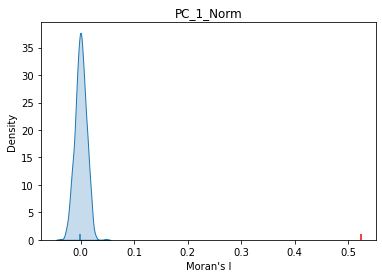

PC_2_Norm : 0.7456558768095785
Prob : 0.001


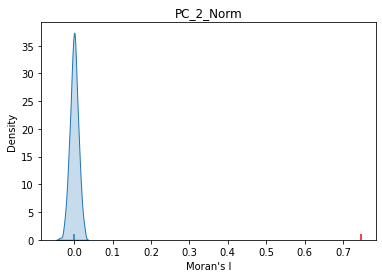

PC_3_Norm : 0.43494567359783887
Prob : 0.001


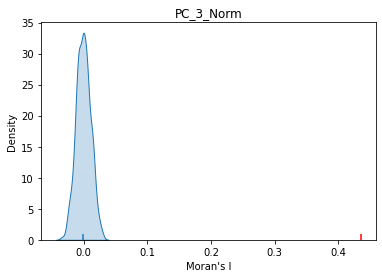

In [23]:
import seaborn as sbn
for i in range(1,4):
    col = 'PC_{}_Norm'.format(i)
    y = gdf[col]
    mi = esda.moran.Moran(y, wq)
    print(col, ':',mi.I)
    print('Prob :', mi.p_sim)
    sbn.kdeplot(mi.sim, shade=True)
    plt.vlines(mi.I, 0, 1, color='r')
    plt.vlines(mi.EI, 0,1)
    plt.xlabel("Moran's I")
    plt.title(col)
    plt.show()

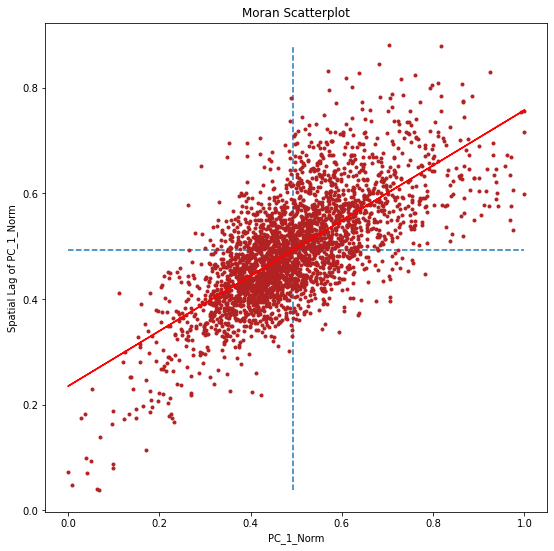

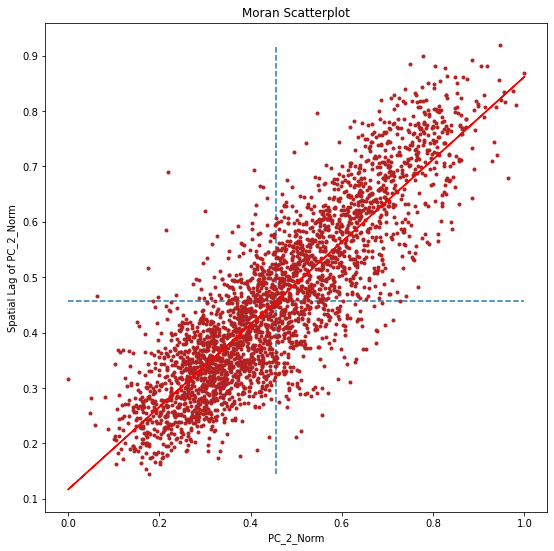

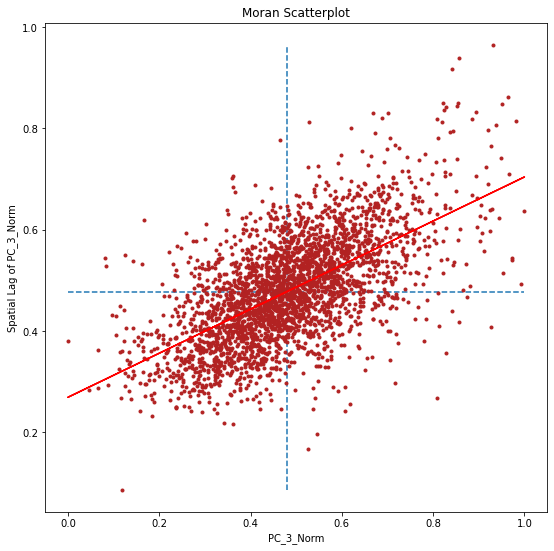

In [26]:
wq.transform = 'r'
for i in range(1,4):
    col = 'PC_{}_Norm'.format(i)
    y = gdf[col]
    lag = lps.weights.lag_spatial(wq, y)
    b, a = np.polyfit(y, lag, 1)
    f, ax = plt.subplots(1, figsize=(9, 9))

    plt.plot(y, lag, '.', color='firebrick')

     # dashed vert at mean of the price
    plt.vlines(y.mean(), lag.min(), lag.max(), linestyle='--')
     # dashed horizontal at mean of lagged price
    plt.hlines(lag.mean(), y.min(), y.max(), linestyle='--')

    # red line of best fit using global I as slope
    plt.plot(y, a + b*y, 'r')
    plt.title('Moran Scatterplot')
    plt.ylabel('Spatial Lag of {}'.format(col))
    plt.xlabel(col)
    plt.show()